In [4]:
import numpy as np
import GPy
import seaborn as sns
import math
import matplotlib.pyplot as plt
import edward as ed
import tensorflow as tf
from edward.models import MultivariateNormalFullCovariance, Normal
from scipy.stats import bernoulli

In [35]:
rate = 300

N = np.random.poisson(rate)
S = np.expand_dims(np.sort(np.linspace(0, 1, N)), axis = 1)
print(N)

297


In [3]:
k = GPy.kern.RBF(input_dim=1,lengthscale=0.1)
mu = np.zeros((N)) # vector of the means
C = k.K(S, S) # covariance matrix
Z = np.random.multivariate_normal(mu,C)
print(C)
sampler = Bernoulli(probs=self._sampling_probability)
sample_id_sampler = Categorical(logits=outputs)

NameError: name 'N' is not defined

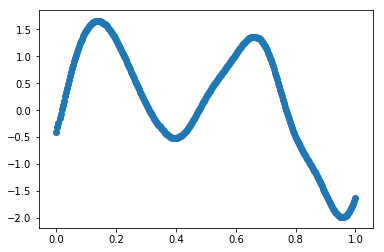

In [37]:
plt.scatter(S, Z)
plt.show()

110


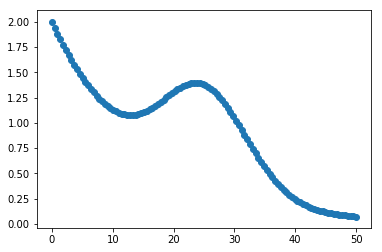

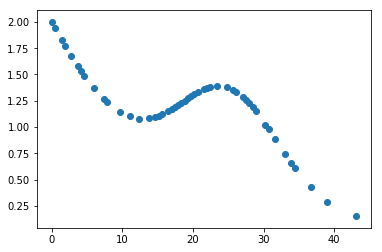

(110, 1)
(49, 1)


In [15]:
def build_toy_dataset1():
    rate = 2
    measure = 50
    N = np.random.poisson(measure * rate)
    S = np.expand_dims(np.sort(np.linspace(0, measure, N)), axis = 1)
    Z = 2*np.exp(-S/15) + np.exp(-((S-25)/10)**2)
    print(N)
    return S, Z, N, rate, measure

def build_toy_dataset2():
    rate = 12
    measure = 5
    N = np.random.poisson(measure * rate)
    S = np.expand_dims(np.sort(np.linspace(0, measure, N)), axis = 1)
    Z = 5 * np.sin(S**2) + 6
    print(N)
    return S, Z, N, rate, measure

k = GPy.kern.RBF(input_dim=1,lengthscale=1)
S, Z, N, rate, measure = build_toy_dataset1()
plt.scatter(S, Z)
plt.show()
R = np.random.uniform(0, 1, N)
V = (Z / rate).flatten()
accept = np.where(R < V)
S_k  = np.take(S, accept, axis=0).reshape(-1,1)
Z_k  = np.take(Z, accept, axis=0).reshape(-1)
plt.scatter(S_k, Z_k)
plt.show()
print(S.shape)
print(S_k.shape)

In [15]:
def conditional(x_new, x, y, k):

    B = k.K(x_new, x)
    C = k.K(x,x)
    A = k.K(x_new, x_new)
    N = len(C)
    mu = B.dot(np.linalg.inv(C + 1e-6*np.eye(N))).dot(y)
    sigma = A - B.dot(np.linalg.inv(C + 1e-6*np.eye(N)).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())

In [8]:
def update():
    
    global x_M, y_M, x_K, y_K
    bern_p = 0.5
    for i in range(10):
        b = bernoulli.rvs(bern_p, size=1)#np.random.binomial(1,bern_p,1)
        M = len(x_M)
        if b==1:
            x_new = np.random.uniform(size=(1,1))
            mu_new, sigma_new = conditional(x_new, np.concatenate((x_K,x_M), axis=0), np.concatenate((y_K, y_M), axis=0), k)
            y_new = np.random.normal(loc=mu_new, scale=np.sqrt(sigma_new))
            ratio = np.log(rate*measure)
            ratio -= np.log(M+1)
            ratio -= np.log(1+np.exp(y_new))
            a = np.random.uniform(0, 1)
            if np.log(a) < ratio:
                x_M = np.concatenate((x_M, x_new), axis=0)
                y_M = np.concatenate((y_M, np.expand_dims(y_new, axis=1)))

        elif M>0:
            c = np.random.choice(M, 1)[0]
            #print(c)
            ratio = np.log(M)
            ratio += np.log(1 + np.exp(y_M[c]))
            ratio -= np.log(rate*measure)
            a = np.random.uniform(0, 1)
            if np.log(a) < ratio:
                #print("Done")
                x_M = np.delete(x_M, c, 0)
                y_M = np.delete(y_M, c)


    ## Sampling the location of thinned events

    for i in range(len(x_M)):   # Use enumerate

        x_new = np.random.uniform(size=(1,1))
        mu_new, sigma_new = conditional(x_new, np.concatenate((x_K,x_M), axis=0), np.concatenate((y_K, y_M), axis=0), k)
        y_new = np.random.normal(loc=mu_new, scale=np.sqrt(sigma_new))
        ratio = np.log(1 + np.exp(y_M[i]))
        ratio -= np.log(1 + np.exp(y_new))

        a = np.random.uniform(0, 1)
        if np.log(a) < ratio:
            x_M[i] = x_new
            y_M[i] = y_new
            
    
    S = np.concatenate((x_K, x_M), axis=0)
    G = np.concatenate((y_K, y_M), axis=0)
    N = S.shape[0]       # Number of data points K+M
    D = S.shape[1]       # Dimension of the space
    C = k.K(S,S).astype(np.float32)
    
    X = tf.constant(C)
    F = tf.Variable(G, name="FunctionVal", dtype=tf.float32)
    prior_loss = 0.5*tf.matmul(tf.expand_dims(F, axis=0), tf.matmul(tf.matrix_inverse(X + 1e-6*tf.eye(N)), tf.expand_dims(F, axis=1)))
    prior_loss = tf.squeeze(prior_loss)
    likelihood_loss = tf.reduce_sum(tf.log(tf.ones([K]) + tf.exp(-tf.slice(F, [0], [K]))))
    likelihood_loss += tf.reduce_sum(tf.log(tf.ones([M]) + tf.exp(tf.slice(F, [K], [M]))))    
    loss = prior_loss + likelihood_loss
    train_op = tf.train.AdadeltaOptimizer(1., 0.95, 1e-6).minimize(loss)
    init_OP = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_OP)
        for i in range(50):
            sess.run(train_op)
            val = sess.run(F)

    return x_M, y_M, val

33.1925
39.9803
54.0508
55.2052
75.2621
71.2533
72.7164
80.785
77.2141
81.0419
80.3433
82.4303
65.1826
76.9085
68.4334
85.4949
97.2743
-20.1824
57.1176
76.9783
100.715
67.7201
86.4092
65.0857
78.2024
90.7185
81.7441
98.579
94.5762
86.7763
86.5566
82.3305
96.0222
116.077
117.624
101.515
91.2069
98.8716
88.6817
104.815
92.5669
102.568
84.1813
83.9572
86.7473
72.5869
72.1735
68.6296
34.9276
82.0186


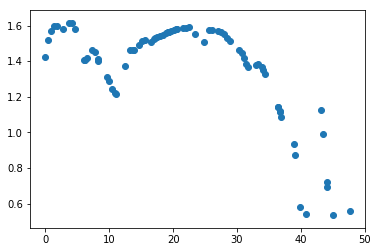

In [17]:
def conditional(x_new, x, y, k):

    B = k.K(x_new, x)
    A = k.K(x_new, x_new)
    C = k.K(x,x)
    N = len(C)
    mu = B.dot(np.linalg.inv(C + 1e-6*np.eye(N))).dot(y)
    sigma = A - B.dot(np.linalg.inv(C + 1e-6*np.eye(N)).dot(B.T))

    return(mu.squeeze(), sigma.squeeze())

bern_p = 0.5
n_iter = 50
x_K, y_K = S_k, Z_k
x_M, y_M = np.empty((0,1)), np.empty((0))
#C = k.K(S,S)
K = len(x_K)
for n in range(n_iter):
    
    for i in range(10):
        b = bernoulli.rvs(bern_p, size=1)#np.random.binomial(1,bern_p,1)
        M = len(x_M)
        if b==1:
            x_new = np.random.uniform(low=0, high=measure, size=(1,1))
            mu_new, sigma_new = conditional(x_new, np.concatenate((x_K,x_M), axis=0), np.concatenate((y_K, y_M), axis=0), k)
            y_new = np.random.normal(loc=mu_new, scale=np.sqrt(sigma_new))
            ratio = np.log(rate * measure)
            ratio -= np.log(M+1)
            ratio -= np.log(1 + np.exp(y_new))
            a = np.random.uniform(0, 1)
            if np.log(a) < ratio:
                x_M = np.concatenate((x_M, x_new), axis=0)
                y_M = np.concatenate((y_M, np.expand_dims(y_new, axis=1)))

        elif M>0:
            c = np.random.choice(M, 1)[0]
            #print(c)
            ratio = np.log(M)
            ratio += np.log(1 + np.exp(y_M[c]))
            ratio -= np.log(rate * measure)
            a = np.random.uniform(0, 1)
            if np.log(a) < ratio:
                #print("Done")
                x_M = np.delete(x_M, c, 0)
                y_M = np.delete(y_M, c)


    ## Sampling the location of thinned events

    for i in range(len(x_M)):   # Use enumerate

        x_new = np.random.uniform(low=0, high=measure, size=(1,1))
        mu_new, sigma_new = conditional(x_new, np.concatenate((x_K,x_M), axis=0), np.concatenate((y_K, y_M), axis=0), k)
        y_new = np.random.normal(loc=mu_new, scale=np.sqrt(sigma_new))
        ratio = np.log(1 + np.exp(y_M[i]))
        ratio -= np.log(1 + np.exp(y_new))

        a = np.random.uniform(0, 1)
        if np.log(a) < ratio:
            x_M[i] = x_new
            y_M[i] = y_new
            
    M = len(x_M)
    S = np.concatenate((x_K, x_M), axis=0)
    G = np.concatenate((y_K, y_M), axis=0)
    N = S.shape[0]       # Number of data points K+M
    D = S.shape[1]       # Dimension of the space
    C = k.K(S,S).astype(np.float32)
    
    X = tf.constant(C)
    F = tf.Variable(G, name="FunctionVal", dtype=tf.float32)
    prior_loss = 0.5*tf.matmul(tf.expand_dims(F, axis=0), tf.matmul(tf.matrix_inverse(X + 1e-6*tf.eye(N)), tf.expand_dims(F, axis=1)))
    prior_loss = tf.squeeze(prior_loss)
    likelihood_loss = tf.reduce_sum(tf.log(tf.ones([K]) + tf.exp(-tf.slice(F, [0], [K]))))
    likelihood_loss += tf.reduce_sum(tf.log(tf.ones([M]) + tf.exp(tf.slice(F, [K], [M]))))    
    loss = tf.add(prior_loss, likelihood_loss)
    train_op = tf.train.AdadeltaOptimizer(0.1, 0.95, 1e-5).minimize(loss)
    init_OP = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_OP)
        for i in range(100):
            l, _ = sess.run([loss,train_op])
            #print(l)
            
        val = sess.run(F)
    print(l)
    y_K, y_M = val[:K], val[K:]
S = np.concatenate((x_K,x_M), axis=0)
plt.scatter(S, rate / (1 + np.exp(-val)))
plt.show()

(49, 1) (79,)


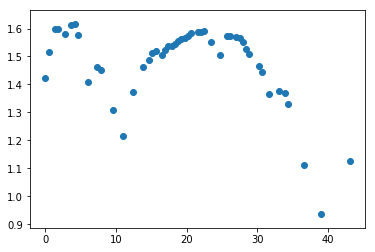

[[  1.00000000e+000   9.00135475e-001   3.87945663e-001 ...,
    7.11633408e-010   5.06444022e-092   6.26233880e-289]
 [  9.00135475e-001   1.00000000e+000   6.56495134e-001 ...,
    1.25774148e-008   5.54218989e-088   1.02038186e-281]
 [  3.87945663e-001   6.56495134e-001   1.00000000e+000 ...,
    2.08981943e-006   3.53043788e-080   1.44099453e-267]
 ..., 
 [  7.11633408e-010   1.25774148e-008   2.08981943e-006 ...,
    1.00000000e+000   2.26269832e-043   2.19255894e-195]
 [  5.06444022e-092   5.54218989e-088   3.53043788e-080 ...,
    2.26269832e-043   1.00000000e+000   8.29094444e-056]
 [  6.26233880e-289   1.02038186e-281   1.44099453e-267 ...,
    2.19255894e-195   8.29094444e-056   1.00000000e+000]]
[[  1.00000000e+00   9.00135458e-01   3.87945652e-01 ...,   7.11633419e-10
    0.00000000e+00   0.00000000e+00]
 [  9.00135458e-01   1.00000000e+00   6.56495154e-01 ...,   1.25774147e-08
    0.00000000e+00   0.00000000e+00]
 [  3.87945652e-01   6.56495154e-01   1.00000000e+00 ...,   

In [18]:
S = np.concatenate((x_K,x_M), axis=0)
print(x_K.shape, val.shape)
plt.scatter(x_K, rate / (1 + np.exp(-val[:K])))
plt.show()
print(k.K(S, S))
print(C)
print(rate, measure)

In [116]:
print(len(x_K), len(x_M))

43 109


152
43 109


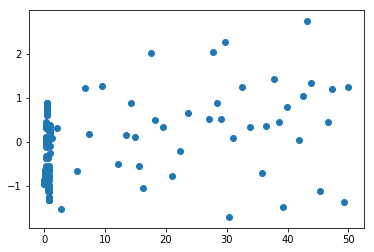

In [117]:

K = len(x_K)
M = len(x_M)
print(N)
print(K,M)
plt.scatter(S, G)
plt.show()

In [118]:
X = tf.constant(C)
F = tf.Variable(G, name="FunctionVal", dtype=tf.float32)

prior_loss = 0.5*tf.matmul(tf.expand_dims(F, axis=0), tf.matmul(tf.matrix_inverse(X + 1e-6*tf.eye(N)), tf.expand_dims(F, axis=1)))
prior_loss = tf.squeeze(prior_loss)

In [152]:
#tf.ones(shape=[K])
#tf.slice(F, [0], [K])
likelihood_loss = tf.reduce_sum(tf.log(tf.ones([K]) + tf.exp(-tf.slice(F, [0], [K]))))
likelihood_loss += tf.reduce_sum(tf.log(tf.ones([M]) + tf.exp(tf.slice(F, [K], [M]))))    
loss = prior_loss + likelihood_loss
train_op = tf.train.AdadeltaOptimizer(0.01, 0.95, 1e-5).minimize(loss)
#train_op = tf.train.GradientDescentOptimizer(1e-7).minimize(loss)
init_OP = tf.global_variables_initializer()

In [153]:
with tf.Session() as sess:
    sess.run(init_OP)
    l = sess.run(loss)
    print(l)
    for i in range(100):
        #print(sess.run(tf.gradients(loss, F)))
        sess.run(train_op)
        l = sess.run(loss)
        print(l)
        
    val = sess.run(F)

134.297
125.113
119.142
113.946
110.888
107.333
105.498
102.833
100.517
98.1052
95.8221
94.0091
92.8328
91.4599
89.4568
88.0087
85.4245
84.8758
83.9912
82.6299
82.4493
80.9882
79.8532
79.3682
79.7241
77.859
77.4693
76.7161
75.6078
75.9333
75.3686
74.7395
73.6898
72.9701
72.6164
72.5333
72.5732
71.5203
71.1612
71.1887
70.4409
70.1507
69.9999
69.5402
69.7339
69.4146
69.2962
68.1166
68.471
68.1797
68.0847
66.6412
67.1202
67.9849
67.9525
66.9779
67.3777
67.0672
65.8616
65.9185
66.5053
66.9086
67.1189
65.3796
66.0831
67.1607
65.2105
66.0994
65.2665
64.5533
65.3542
66.0296
65.9048
64.9904
65.2198
65.0133
66.1422
65.0739
65.9751
65.3205
64.5728
66.4175
64.6346
65.4895
66.3591
65.5115
65.0442
64.8456
65.0298
64.8639
64.3379
64.864
65.0875
64.8722
64.9092
65.5037
64.9661
64.2527
65.3959
64.8976
65.243


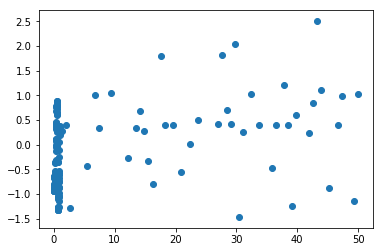

In [121]:
plt.scatter(S, val)
plt.show()